Using the XGBoost to model the bandgap for the dataset Stoich 45 intersection.

In [16]:
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Using the dataset Stoich45_FeatureSelected_dataset

In [17]:
train_dataset=pd.read_csv('../../Data/datasets_main/Stoich45_FeatureSelected_dataset.csv')  


In [18]:
train_dataset.head()

,atomic_num_standard_deviation,atomic_num_max,group_num_mean,period_num_mean,electronegativity_min,electron_affinity_mean,electron_affinity_geometric_mean,electron_affinity_standard_deviation,melting_mean,melting_geometric_mean,...,density_geometric_mean,density_standard_deviation,density_max,ionization_energy_mean,ionization_energy_geometric_mean,ionization_energy_standard_deviation,ionization_energy_max,ionization_energy_geometric_min,outputs.hse06.bandgap,MOF
0,5.689851,29.0,7.960000,1.600000,1.90,100.252000,82.167123,45.559861,1143.143600,107.487344,...,4.182460,1912.665927,8960.0,1233.652000,1223.402105,146.933016,1402.3,745.5,3.751390,qmof-0000295
1,3.088689,19.0,13.700000,2.050000,0.82,110.030000,72.816144,57.821122,1199.022000,206.066393,...,15.205775,1023.803409,2260.0,1218.510000,1187.405501,219.174061,1402.3,418.8,3.014584,qmof-000512e
2,6.272068,30.0,10.363636,1.818182,1.65,100.818182,0.000000,58.491030,1114.843636,141.329527,...,8.874182,1680.181346,7140.0,1230.522727,1221.752785,142.324105,1402.3,906.4,3.284171,qmof-00052d0
3,8.169828,48.0,8.687500,1.656250,1.69,110.787500,0.000000,42.372240,1231.431562,122.519183,...,5.589511,1726.258029,8650.0,1228.065625,1221.424040,122.525772,1313.9,867.8,5.170849,qmof-0006638
4,4.436880,27.0,9.097561,1.658537,1.88,104.460976,82.484786,49.421674,1552.056341,186.153480,...,10.509249,1648.227778,8900.0,1219.541463,1210.807020,139.686543,1402.3,760.4,3.978235,qmof-002580c


In [19]:

train_dataset.drop(columns=['MOF'], inplace=True)
# Rename the target column to 'HSE06Bandgap' for consistency
train_dataset.rename(columns={'outputs.hse06.bandgap': 'HSE06Bandgap'}, inplace=True)

##### Define the Feature dataset and the target.

In [20]:
X= train_dataset.drop(columns=['HSE06Bandgap'])  # Features
y = train_dataset['HSE06Bandgap']  # Target variable

#### Generate the model LGBMRegressor

In [21]:
model = LGBMRegressor(
    objective='regression',
    metric='rmse',
    n_jobs=-1,  # Use all available cores
    verbose=-1,  # Suppress LightGBM output
    boosting_type='gbdt',  # Gradient Boosting Decision Tree
    num_leaves=31,  # Maximum number of leaves in one tree
    min_data_in_leaf=20,  # Minimum number of samples in one leaf
    max_bin=255,  # Maximum number of bins for discretizing continuous features
    feature_fraction=0.8,  # Fraction of features to consider at each split
    bagging_fraction=0.8,  # Fraction of samples to use for bagging
    bagging_freq=5,  # Perform bagging every 5 iterations
    learning_rate=0.1,  # Step size shrinkage to prevent overfitting
    n_estimators=1000,  # Number of boosting iterations
    random_state=42,  # For reproducibility
)


RMSE scores for each fold: [0.53566611 0.52014151 0.54891917 0.54799865]
Mean RMSE: 0.5381813610359132
Std Dev of RMSE: 0.011655926534267485
Fractional Errors for each fold: [0.18890527 0.1902873  0.19191183 0.19170767]
Mean Fractional Error: 0.1907030167756094
Std Dev of Fractional Error: 0.001211945144923697


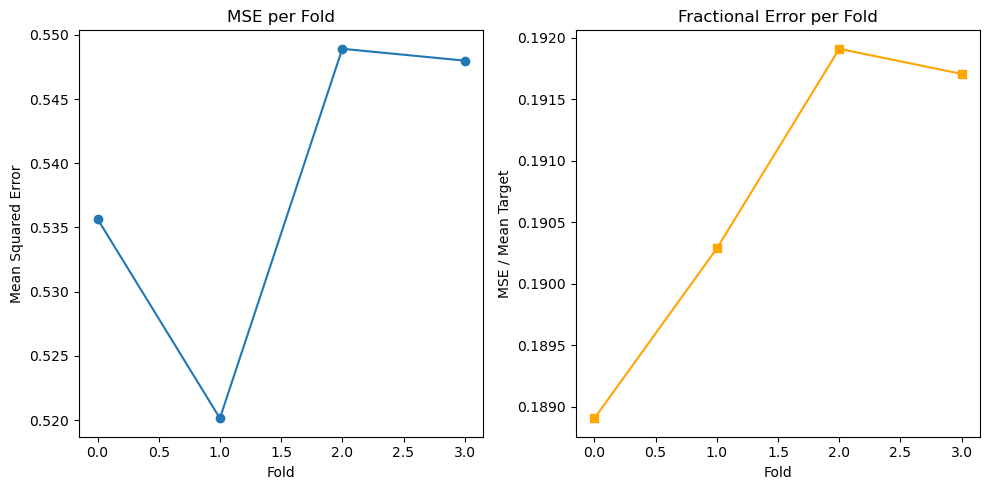

In [22]:

kfold = KFold(n_splits=4, shuffle=True, random_state=1234)
# Fit the model using cross-validation and get mean CV MSE and fractional error
def get_mean_cv_mse_and_frac_error(model, X, y, kfold):
    validation_target_means = [y[test_index].mean() for _, test_index in kfold.split(X)]
    mses = -cross_val_score(
        model,
        X, y,
        cv=kfold, scoring='neg_mean_squared_error',
        n_jobs=4
    )
    frac_errors = np.sqrt(mses) / validation_target_means

    return (mses, np.sqrt(mses) / validation_target_means)
mses, frac_errors = get_mean_cv_mse_and_frac_error(model, X, y, kfold)
print("RMSE scores for each fold:", mses)
print("Mean RMSE:", mses.mean())
print("Std Dev of RMSE:", mses.std())
print("Fractional Errors for each fold:", frac_errors)
print("Mean Fractional Error:", frac_errors.mean())
print("Std Dev of Fractional Error:", frac_errors.std())
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mses, marker='o')
plt.title("MSE per Fold")
plt.xlabel("Fold")
plt.ylabel("Mean Squared Error")

plt.subplot(1, 2, 2)
plt.plot(frac_errors, marker='s', color='orange')
plt.title("Fractional Error per Fold")
plt.xlabel("Fold")
plt.ylabel("MSE / Mean Target")
plt.tight_layout()
plt.show()
# Ensure the model is fitted before calculating CV MSE and fractional error




## Measures the improvement in loss (e.g., reduction in MSE) that each split on a feature provides.

In [23]:

model.fit(X, y)
RMSE = np.sqrt(mean_squared_error(y, model.predict(X)))
MAE= mean_absolute_error(y, model.predict(X))
R2= model.score(X, y)
print("Final Model Performance:")
print("Root Mean Squared Error (RMSE):", RMSE)
print("Mean Absolute Error (MAE):", MAE)
print("R-squared (R2):", R2)



Final Model Performance:
Root Mean Squared Error (RMSE): 0.19011749890934596
Mean Absolute Error (MAE): 0.1337224515232654
R-squared (R2): 0.9684667746271461
